# TempEst-NEXT Validation Suite

This Notebook provides a standard suite of model tests for TempEst-NEXT.  This serves two purposes:

1. Reproducibility of research.  This notebook is used to generate final manuscript figures relating to model performance. The notebook itself is provided with the published model and dataset, allowing exact reproducibility (and easy modification) of the analysis.
2. Efficient, consistent testing.  After modifying the model, running this notebook is a quick way to make sure everything still works and to assess performance impacts.

For validation, we use two pre-retrieved datasets as well as some automatic retrieval of new data.  The two pre-retrieved datasets are a "development" set of ~900 USGS gages (nominally 1,000; 900ish with overlapping data coverage) and a "test" set of 331 (nominal 400) USGS gages paired with daymet meteorology, 3DEP topography, NLCD land cover, etc.  The development set was used for model development and tuning, while the test set is reserved for final validation (i.e., here).  Test-set validations have been run during the development process, but are never used to directly inform model design.

The test suite also illustrates model runtime.

Some cells were used for initial data preparation, but do not need to be rerun.  These have been set to "raw" rather than Python, so simply running the entire Notebook will run all tests but nothing extraneous.

## Assessed Model Characteristics

The goal is to assess several model performance characteristics.  Forecasting is used for a handful of tests, but most analysis focuses on hindcasting for computational convenience.  It is assumed that any performance discrepancies in forecasting vs hindcasting would be apparent in the tests that cover both, and thus that not every analysis needs to test forecasting.

In this notebook, forecasting is primarily tested by using archived weather forecasts to predict what the forecast would have been for time periods where observations are available, which is necessary for automatic testing.  There is code to run a "real" forecast, but this cannot be automatically evaluated because observations are not available, so the user is left to go back and check once observations are available.

1. Calibrated model hindcasting and forecasting performance, using TempEst-NEWT like a typical single-watershed model
2. General ungaged hindcasting and forecasting performance
3. Ungaged-region hindcasting performance
4. Ungaged-elevation hindcasting performance
5. Ungaged-time-period hindcasting performance
6. Disturbance hindcasting performance
7. Small-stream hindcasting performance?

## Tests

The following tests are used to assess the above performance characteristics.  Forecast tests cover just 2022, since HRRR retrieval is slow.

- Calibrated testing: train a model on the first 70% of observations for each stream, then evaluate performance for predicting the last 30%.  This uses the full dataset.
  - Use meteorology estimates (daymet) for training and testing: hindcast test.  Because the model architecture does not actually use "today's" weather (up through yesterday only), this is also a 24-hour forecast test.
  - Use weather forecast archives (HRRR, GFS/GEFS) for training and testing: forecast test.  Test forecast periods of 1, 2, 3 days.  Note forecast period is 1 day *past* the last day of the weather forecast, since NEWT does not depend on day-of weather.
  - Use meteorology estimates for training and forecasts for testing: evaluate the impact of heterogeneous datasets.  Use 2-day HRRR-forced forecast only.
- Gagewise cross-validation: partition development dataset gages into *k* equal sets.  Train a model on all partitions but one, and evaluate performance for predicting the excluded partition.  This tests general ungaged performance, not accounting for any potential impact of having used the same dataset for model tuning.  Hindcasting (met estimate) only.  This uses the development dataset to show whether model tuning introduced any performance discrepancies (compared to test set validation).
- Test set validation: train a model on the development set, and evaluate performance for predicting the test set.  This tests general ungaged performance for a fully-independent dataset.
  - Meteorology estimates (hindcast)
  - Weather forecast archives (forecast) for 1 (today), 2, and 3-day forecasts.  This has to be done with HRRR, since GFS doesn't have as readily-available long-term archives.
    - Trained on estimates/test on forecasts (forecast with heterogeneous data).
- Extrapolation hindcasting tests: partition the combined development and testing sets along some characteristic of interest, and use a model trained on one group to predict the other group.  This tests the ability of TempEst-NEXT to extrapolate in terms of specific characteristics.  All hindcasting.
  - Regional: partition the CONUS into contiguous regions and run leave-one-out cross-validation over the regions.
  - Elevation: train a model on the lower elevations and predict higher elevations.  Partial dependency plots and previous research suggest there is a major shift in watershed dynamics around 2300 m, and it is difficult to extrapolate past that barrier.
  - Time (walk-forward validation): train a model up to a given year, then predict the next year.  This tests whether the model can extrapolate forward in time.
- Regime-shift hindcasting: identify a set of watersheds for which the observed thermal regime has shifted significantly.  Train the model on everything else, then try to predict the disturbed watersheds and see how the model performs.  This assesses whether TempEst-NEXT is capable of capturing regime shifts.
- Small-stream hindcasting: if possible, use the model to predict temperatures at very small (e.g., first-order headwaters, centimeters to a few meters wide) streams where some observations are available, just to see if it works there.

# Data Preparation

In [1]:
import NEXT
import NEWT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import dataretrieval.nwis as nwis
import geopandas as gpd
import matplotlib.animation as anim
import shapely
warnings.catch_warnings(action="ignore")
bp = "/scratch/dphilippus/notebooks/next_validation/"

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


There are some major outliers that are either erroneous (negative temperatures) or wildly unrepresentative (hot springs) that we remove to produce realistic performance estimates.

In [ ]:
dev_data = pd.read_csv(bp + "DevData.csv", dtype={"id": "str"}, parse_dates=["date"]).drop(columns=["swe", "tmin"]).dropna()
dev_data = dev_data[(dev_data["temperature"] > -0.5) & (dev_data["temperature"] < 40)]
test_data = pd.read_csv(bp + "TestData.csv", dtype={"id": "str"}, parse_dates=["date"]).dropna()
test_data["day"] = test_data["date"].dt.day_of_year
all_data = pd.concat([dev_data, test_data])
test_data_hrrr = pd.read_csv(bp + "TestDataHRRR3.csv", dtype={"id": "str"}, parse_dates=["date"])

### Forecast Archive Retrieval (does not need to be run)

A one-month run takes 0.02 hours, so 72 months should be about 1.5 hours, for a total of ~500 core-hours for the test set.  Needs to be run distributed.

In [93]:
hrrr_files = os.listdir(bp + "hrrr/")
hrrr = pd.concat([pd.read_csv(bp + "hrrr/" + f, parse_dates=["date"]).assign(id=f.split(".")[0]) for f in hrrr_files])

In [95]:
test_data_hrrr = test_data.drop(columns={"tmax", "prcp"}).merge(hrrr, on=["id", "date"], how="inner")
test_data_hrrr.to_csv(bp + "TestDataHRRR3.csv", index=False)

### Data Preprocessing (does not need to be run)

# Calibrated Tests

Full dataset.

In [ ]:
def cut_dev(gid, data, start=None):
    idd = data[data["id"] == gid]
    if idd["temperature"].mean() > 35 or idd["temperature"].mean() < 0:
        return (None, None)  # bad data or major outlier
    if start is None:
        cut = round(len(idd) * 0.7)
        if cut >= 365:
            return (idd.iloc[cut:], idd["date"].iloc[cut+1])
        else:
            return (None, None)  # dataset too small
    else:
        return idd[idd["date"] >= start]

def cal_val(gid, data, test_data = None, cal_fn = cut_dev, val_fn = cut_dev):
    (train, cutoff) = cal_fn(gid, data)
    if test_data is None:
        test_data = data
    try:
        if cutoff is not None:
            test = cal_fn(gid, data, cutoff)
            model = NEWT.Watershed.from_data(train)
            return model.run_series(test)
    except Exception as e:
        warnings.warn(str(e))

## Hindcast

In my last test, 919 watersheds took 26 minutes to train and predict, for about 2 seconds per watershed.

In [ ]:
file = bp + "results/calibrated_hindcast.csv"
rerun = False
if not rerun and os.path.exists(file):
    preds = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = pd.concat([cal_val(x, all_data) for x in all_data["id"].unique()])
    runtime = (time.time() - start) / 60
    count = len(preds["id"].unique())
    print(f"Trained and ran {count} watershed models in {runtime:.1f} minutes.")
    preds.to_csv(file, index=False)

In [11]:
preds = preds[abs(preds["anom"]) < 10]  # I don't know why one of the models is predicting colossal anomalies, but it is.

Overall performance summary below.  Note that stationarity, in particular, does absurdly well as a comparison point (same temperature today as yesterday).  As far as I'm aware, this comparison has not been run for most previous models.  It would be interesting to see how much of a lag is required for NEWT to outperform stationarity.  This does suggest that, if you have observations, "same as yesterday" is probably a better bet than most non-data-assimilating models.

Interestingly, when a massive outlier that was predicting anomalies in the thousands of degrees is removed, global performance is very similar to gagewise performance.  Note that huge anomaly sensitivity isn't representative of any real use case, since in a calibrated model that would be corrected for and the (smoothed) coefficient estimation model won't predict such high sensitivity.  (If it did happen, it would be fairly obvious that ~3000 C is not a reasonable estimate.)

In [12]:
with warnings.catch_warnings(action="ignore"):
    print(preds.groupby("id").apply(NEWT.analysis.perf_summary).describe())

               R2        RMSE         NSE  StationaryNSE  ClimatologyNSE  \
count  919.000000  919.000000  919.000000     919.000000      919.000000   
mean     0.922989    1.546113    0.921905       0.976469        0.951487   
std      0.093415    0.452127    0.094815       0.017752        0.050719   
min      0.088175    0.121245    0.080547       0.855635        0.287647   
25%      0.922307    1.302331    0.921413       0.969239        0.935466   
50%      0.944833    1.525055    0.944021       0.980354        0.957607   
75%      0.961269    1.743604    0.960591       0.988588        0.979532   
max      0.988151    7.747312    0.987592       0.999010        1.000000   

       AnomalyNSE       Pbias        Bias     MaxMiss  
count  809.000000  919.000000  919.000000  919.000000  
mean     0.469592    0.059031    0.005099    1.269894  
std      0.217867    0.756563    0.085364    0.823254  
min     -0.115634   -9.045654   -1.071412    0.015025  
25%      0.320645   -0.140384   -0.

In [13]:
NEWT.analysis.perf_summary(preds)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.96032,1.55536,0.960308,0.983883,0.596827,0.907527,0.027096,0.003624,1.470983


## Forecast

### Homogeneous Forecast
Trained and tested with HRRR.  Note this limits the data coverage (~2018-22).

### Heterogeneous Forecast
Trained with Daymet, tested with HRRR.

# Gagewise Cross-Validation

Runtime: 1.9 hours for 930 sites and ~3M observations.  That makes >1.5 years/second, assuming most of the time is prediction, and a total of 7.5 seconds per site.

In [3]:
# Modbuilder: data -> (ws -> prediction)
logfile = bp + "results/kfold_log.txt"
def make_modbuilder(use_clim, lookback):
    def next_modbuilder(data):
        nx = NEXT.NEXT.from_data(data)
        def prd(x):
            print("|", end="")
            try:
                # return nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt().coefs_to_df()
                return nx.run(x, reset=True, use_climate=use_clim, climyears=lookback)
                # mod = nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt()
                # mod.dynamic_engine = None
                # return mod.run_series(x)
            except KeyboardInterrupt as e:
                raise e
            except Exception as e:
                print("Error", end="")
                with open(logfile, "a") as lf:
                    lf.write(f"Error in gage {x["id"].iloc[0]} for use_clim={use_clim} and lookback={lookback}: {e}\n")
                return None
        return prd
    return next_modbuilder

In [4]:
clim=True
lookback = 10
timing = bp + "results/kfold_times.txt"
out = bp + "results/kfold.csv"
rerun=False
with warnings.catch_warnings(action="ignore"):
    start = time.time()
    kfr = NEWT.analysis.kfold(dev_data, make_modbuilder(clim, lookback), output=out, redo=rerun)
    if rerun:
        print(f"\nLookback: {lookback} : {(time.time() - start) / 3600: .2f} hours for {len(dev_data["id"].unique())} sites with {len(dev_data)} observations")

In [5]:
with warnings.catch_warnings(action="ignore"):
    perf = kfr.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,930.000000,930.000000,930.0,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000
mean,40.026628,-93.811030,0.0,0.900803,2.387733,0.380830,0.976332,0.914292,0.386612,3.679602,0.248052,2.598779
std,4.523078,17.162699,0.0,0.119894,1.196850,6.204710,0.018041,0.067179,0.507173,14.219460,1.535173,1.863113
min,26.975000,-124.392987,0.0,0.004947,0.979030,-179.489478,0.858323,0.175511,-8.886790,-69.256867,-20.804462,0.210280
25%,37.730067,-109.914285,0.0,0.896303,1.804525,0.797733,0.969350,0.900908,0.276590,-2.921607,-0.388746,1.225313
50%,40.132276,-86.506671,0.0,0.935214,2.115198,0.895650,0.980213,0.928499,0.497082,2.219166,0.271068,2.227446
75%,43.005340,-79.581111,0.0,0.955006,2.657320,0.933115,0.988382,0.949361,0.639041,7.629190,0.952882,3.468578
max,48.998814,-67.803889,0.0,0.981016,21.522061,0.974567,0.999005,0.988499,0.793156,166.034819,6.844878,20.665994


## Plots

In [10]:
states = gpd.read_file("usa_states/cb_2018_us_state_20m.shp")
states = states[-states["STUSPS"].isin(["AK", "HI", "PR"])]

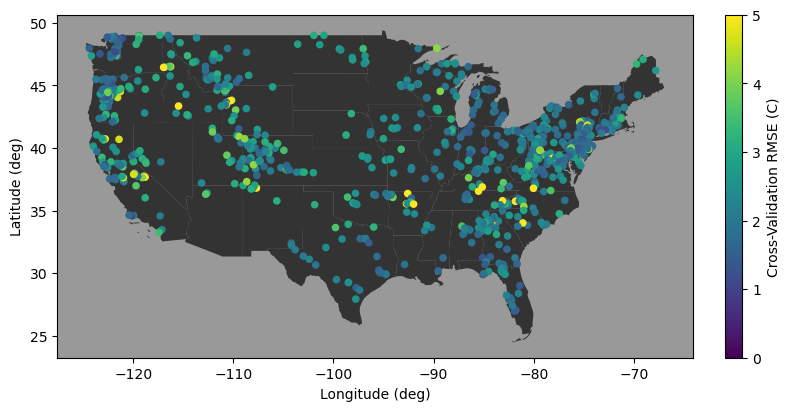

In [37]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#333")
perf.plot.scatter(x="lon", y="lat", c="RMSE", ax=ax, colormap="viridis", vmin=0, vmax=5)
cb = ax.collections[1].colorbar
cb.set_label("Cross-Validation RMSE (C)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_rmse.png", dpi=1000)

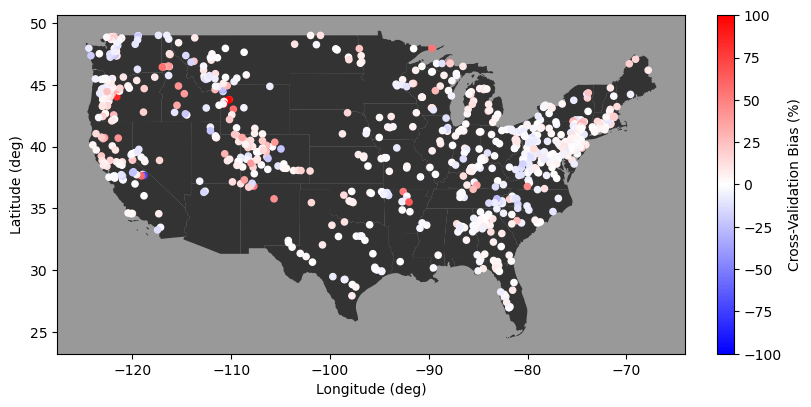

In [38]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#333")
perf.plot.scatter(x="lon", y="lat", c="Pbias", ax=ax, colormap="bwr", vmin=-100, vmax=100)
cb = ax.collections[1].colorbar
cb.set_label("Cross-Validation Bias (%)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_bias.png", dpi=1000)

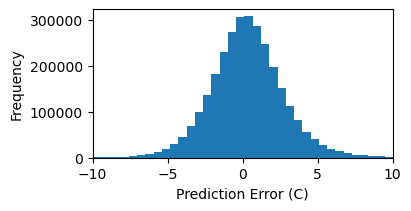

In [26]:
fig = plt.figure(figsize=(4, 2), layout="compressed")
ax = plt.axes()
kfr["error"] = kfr["temp.mod"] - kfr["temperature"]
kfr["error"].plot.hist(bins=100, ax=ax)
ax.set_xlim(-10, 10)
ax.set_xlabel("Prediction Error (C)")
plt.savefig("val_figures/ErrorHist_xv.png", dpi=1000)

In [6]:
ecos = gpd.read_file("ecoregions/NA_CEC_Eco_Level1.shp").to_crs(4326)

In [7]:
def get_name(df):
    if len(df) > 0:
        return df.iloc[0]["NA_L1NAME"].title()
    else:
        return "NA"
perf_pts = gpd.GeoSeries([shapely.Point(x.lon, x.lat) for x in perf.itertuples()])
pt_ecos = pd.Series([get_name(ecos[ecos.contains(x)]) for x in perf_pts])

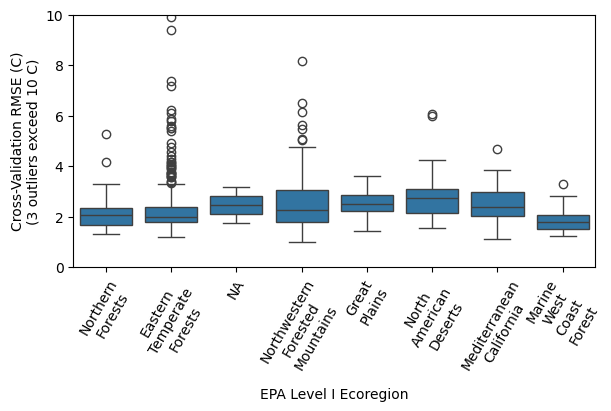

In [13]:
fig = plt.figure(figsize=(6, 4), layout="compressed")
ax = plt.axes()
perf["ecoregion"] = [x.replace(" ", "\n") for x in pt_ecos]
sns.boxplot(perf, y="RMSE", x="ecoregion", ax=ax)
plt.xticks(rotation=60)
ax.set_ylim(0, 10)
ax.set_xlabel("EPA Level I Ecoregion")
ax.set_ylabel("Cross-Validation RMSE (C)\n(3 outliers exceed 10 C)")
plt.savefig("val_figures/EcoregionRMSEBox.png", dpi=1000)

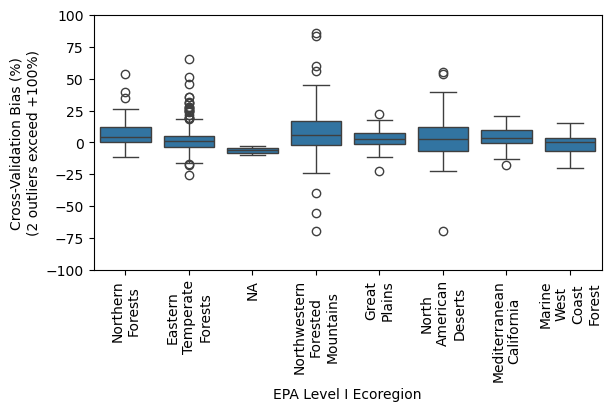

In [93]:
fig = plt.figure(figsize=(6, 4), layout="compressed")
ax = plt.axes()
perf["ecoregion"] = [x.replace(" ", "\n") for x in pt_ecos]
sns.boxplot(perf, y="Pbias", x="ecoregion", ax=ax)
plt.xticks(rotation=90)
ax.set_ylim(-100, 100)
ax.set_xlabel("EPA Level I Ecoregion")
ax.set_ylabel("Cross-Validation Bias (%)\n(2 outliers exceed +100%)")
plt.savefig("val_figures/EcoregionBiasBox.png", dpi=1000)

#### Animation

This animation isn't really a useful general validation; it pairs with the CONUS-scale weekly mean temperature animation generated for AGU, and so covers the same times.

In [34]:
error_steps = kfr.assign(error = lambda x: x["temp.mod"] - x["temperature"],
                        week = lambda x: x["date"].dt.isocalendar().week,
                        year = lambda x: x["date"].dt.year).\
    groupby(["id", "year", "week"]).agg({"lat": "first", "lon": "first", "error": "mean"}).reset_index()
error_steps = error_steps[error_steps["year"] >= 2018].sort_values(["year", "week"])
error_steps["timestep"] = error_steps["year"].astype("str") + " week " + error_steps["week"].astype("str")

In [35]:
error_steps

,id,year,week,lat,lon,error,timestep
826,01018035,2018,1,46.181111,-67.803889,0.100000,2018 week 1
1654,010642505,2018,1,44.083889,-71.285556,-0.725566,2018 week 1
1981,01072870,2018,1,43.234805,-70.956451,0.236493,2018 week 1
2530,01091000,2018,1,43.014805,-71.641461,0.262542,2018 week 1
2864,01093852,2018,1,42.842586,-71.706740,0.126279,2018 week 1
...,...,...,...,...,...,...,...
428906,301141089320300,2022,52,30.194722,-89.534167,1.242415,2022 week 52
429178,383926107593001,2022,52,38.657207,-107.992289,2.583124,2022 week 52
430438,394220106431500,2022,52,39.705000,-106.725833,1.509048,2022 week 52
431605,404417108524900,2022,52,40.738056,-108.880278,1.028745,2022 week 52


MovieWriter ffmpeg unavailable; using Pillow instead.


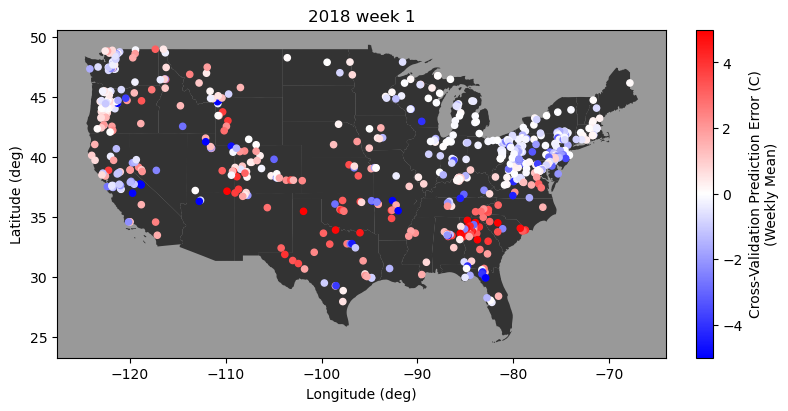

In [36]:
fig = plt.figure(figsize=(10, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
dates = np.array(error_steps["timestep"].unique())

def animate(i):
    date = dates[i]
    fig.clear()
    ax = plt.axes(facecolor="#999")
    states.plot(ax=ax, color="#333")
    error_steps[error_steps["timestep"] == date].plot.scatter(x="lon", y="lat", c="error", ax=ax, colormap="bwr", vmin=-5, vmax=5)
    ax.collections[1].colorbar.set_label("Cross-Validation Prediction Error (C)\n(Weekly Mean)")
    ax.set_xlabel("Longitude (deg)")
    ax.set_ylabel("Latitude (deg)")
    ax.set_title(date)

a = anim.FuncAnimation(fig, animate, interval=150, frames=range(len(dates)))
a.save("val_figures/errors_anim.gif")

# Test Set Validation

In [98]:
start = time.time()
with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(dev_data)
runtime = int(time.time() - start)
print(f"Took {runtime} seconds to train")

Took 40 seconds to train


## Hindcast

This (full timeseries for 750k rows/331 watersheds) took 22 minutes, 1300 seconds.  As before, that's about 1.5 years per second.  The next run took 1200 seconds.

In [97]:
def predict(ws):
    print("|", end="")
    return model.run(ws, reset=True)

In [ ]:
ppath = bp + "results/TestSet_hindcast.csv"
rerun = False
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

In [99]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,320.000000,320.000000,320.0,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,39.902969,-95.030326,0.0,0.891438,2.323557,-0.014870,0.977027,0.913633,0.377982,2.992126,0.247069,2.434158
std,4.643460,17.260681,0.0,0.132654,0.915519,9.491957,0.019028,0.076485,0.506228,12.946045,1.207531,1.696847
min,28.332787,-124.357089,0.0,0.049306,1.014801,-162.730885,0.824755,0.339466,-6.398861,-25.892458,-4.117854,0.272657
25%,36.555978,-111.425710,0.0,0.882338,1.776184,0.796116,0.970903,0.898901,0.275338,-3.279475,-0.443669,1.103735
50%,40.175895,-87.479876,0.0,0.932807,2.147733,0.892361,0.980564,0.931081,0.482934,1.737829,0.209406,2.095300
75%,43.327292,-81.167361,0.0,0.955278,2.522945,0.933999,0.989143,0.949809,0.611706,6.937726,0.861701,3.373150
max,48.984601,-67.935278,0.0,0.982223,7.669616,0.977516,0.999024,0.996135,0.811795,127.480840,5.361551,10.272771


## Reforecast (heterogeneous)

Note that the time period is not the same as the hindcast test, due to limited HRRR archive coverage.

Data retrieval uses the *earliest* HRRR run covering a given date (i.e., 48 hours out), so this is a 3-day forecast lead time (it uses this morning's forecast - where today's max temperature is itself one day of forecast - to predict the day after tomorrow).  It goes a day past the HRRR coverage because the day-of weather isn't actually used.

For comparison purposes here, the median R2 of pure climatology (i.e., fitted seasonality) is 0.90.  Stationarity probably does better than NEXT, but stationarity isn't actually available in an ungaged context - though, of course, neither is climatology!

RMSE did increase a fair bit, to 2.8 C.  That seems to be driven by an increase in bias (to 12%/1.7 C), which probably has to do with the heterogeneous training data.  (Next up: pull HRRR for the full dataset and do a homogeneous run.)  Still, the R2 is better than climatology at 0.91.

In [99]:
def predict(ws):
    print("|", end="")
    return model.run(ws, reset=True)

In [100]:
ppath = bp + "results/TestSet_reforecast.csv"
rerun = False
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data_hrrr.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 619 seconds to predict


In [101]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,301.000000,301.000000,301.0,300.000000,301.000000,301.000000,301.000000,301.000000,296.000000,301.000000,301.000000,301.000000
mean,39.917495,-95.448407,0.0,0.877297,3.141572,-1.556272,0.977199,0.929881,0.068063,13.261840,1.640345,2.815747
std,4.690828,17.355132,0.0,0.132383,1.485586,23.969546,0.020171,0.071492,1.550800,18.219675,1.906618,2.311478
min,28.332787,-124.357089,0.0,0.044562,1.362760,-390.729634,0.824468,0.335259,-24.843842,-100.000000,-14.337017,0.289011
25%,36.608711,-111.741025,0.0,0.869731,2.369925,0.641324,0.971258,0.920617,0.036242,6.553750,0.821062,1.261008
50%,40.038500,-87.832804,0.0,0.913866,2.768227,0.815549,0.980659,0.945719,0.251232,12.373834,1.707521,2.148457
75%,43.360833,-81.227879,0.0,0.941379,3.488590,0.890639,0.989561,0.961177,0.445348,19.273629,2.500406,3.624457
max,48.984601,-67.935278,0.0,0.979441,15.365064,0.956395,0.999039,1.000000,0.755046,153.275769,12.195286,15.780000


# Extrapolation Tests

## Regional

For regional extrapolation, we split the CONUS into 16 grid cells (four-by-four), of which 15 actually contain gages and 14 have more than 1 gage.  Across those 14, we run a leave-one-out cross-validation, training a model on the other 13 and predicting all gages in the left-out grid cell.  This tests the ability of the model to make predictions for contiguous regions with no gages, meaning that it has no training data from nearby sites and has to go off its knowledge of general trends.

The cell 0x0 (southwesternmost) only has one gage in it, so results from that one should probably be ignored, but we'll include it.  The next fewest gages is 9, in Maine (3x3).  Some cells are, of course, considerably sparser than others, and gage count additionally varies with the size of cells on the US borders, as in the case of both 0x0 and 3x3.

<Axes: xlabel='lon', ylabel='lat'>

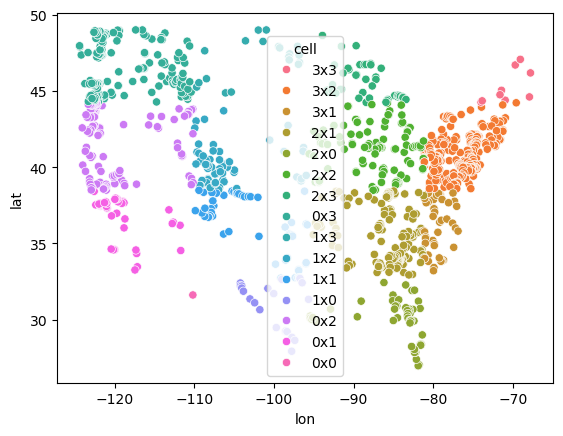

In [54]:
N = 4
latmin = all_data["lat"].min()
latmax = all_data["lat"].max() + 1
lonmin = all_data["lon"].min()
lonmax = all_data["lon"].max() + 1
latstep = (latmax - latmin)/N
lonstep = (lonmax - lonmin)/N

all_data["lat_cell"] = ((all_data["lat"] - latmin) / latstep).astype("int")
all_data["lon_cell"] = ((all_data["lon"] - lonmin) / lonstep).astype("int")
all_data["cell"] = all_data["lon_cell"].astype("str") + "x" + all_data["lat_cell"].astype("str")
sns.scatterplot(all_data.groupby("id")[["lat", "lon", "cell"]].first(), x="lon", y="lat", hue="cell")

In [55]:
def modbuilder(data):
    nx = NEXT.NEXT.from_data(data)
    print("New region", end="")
    def prd(x):
        print("|", end="")
        try:
            return nx.run(x, reset=True)
        except KeyboardInterrupt as e:
            raise e
        except:
            return None
    return prd
with warnings.catch_warnings(action="ignore"):
    spatxv = NEWT.analysis.kfold(all_data, modbuilder, by='cell', k=1, output = bp + "results/SpatialXV.csv")

New region||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region||||||||||||||||||||||||||||||||||||||||||||New region||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [57]:
with warnings.catch_warnings(action="ignore"):
    spatperf = spatxv.groupby(["id", "cell"]).apply(NEWT.analysis.perf_summary)

Globally, there is almost no penalty, with RMSE increasing to 2.2 C.  Bias is a little higher though.

In [59]:
spatperf.describe()

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,0.894993,2.457665,0.184618,0.976510,0.914123,0.340543,4.571679,0.355039,2.580611
std,0.124802,1.174829,8.361090,0.018294,0.069649,0.598902,14.938509,1.531902,1.874864
min,0.004163,0.985339,-201.498769,0.824755,0.175511,-10.915351,-72.205736,-20.988465,0.139555
25%,0.886972,1.849460,0.779444,0.969726,0.900634,0.239977,-2.777347,-0.358910,1.246836
50%,0.932874,2.185256,0.888914,0.980282,0.928919,0.491661,2.687977,0.348076,2.092605
75%,0.954586,2.740518,0.928626,0.988677,0.949541,0.625497,8.515997,1.070620,3.481772
max,0.982014,21.759686,0.973796,0.999024,0.996135,0.808417,165.951091,7.136250,20.514383


In [71]:
spatperf.groupby("cell")["RMSE"].median()

cell
0x0    3.587558
0x1    2.362715
0x2    2.589592
0x3    2.123704
1x0    2.130582
1x1    2.566979
1x2    2.696461
1x3    2.848734
2x0    1.976696
2x1    2.094703
2x2    2.085010
2x3    2.201737
3x1    2.309398
3x2    2.087197
3x3    2.811725
Name: RMSE, dtype: float64

Performance does vary somewhat with region, but all (except the single-gage one) have a median RMSE of 2.0-3 C.

(0.0, 10.0)

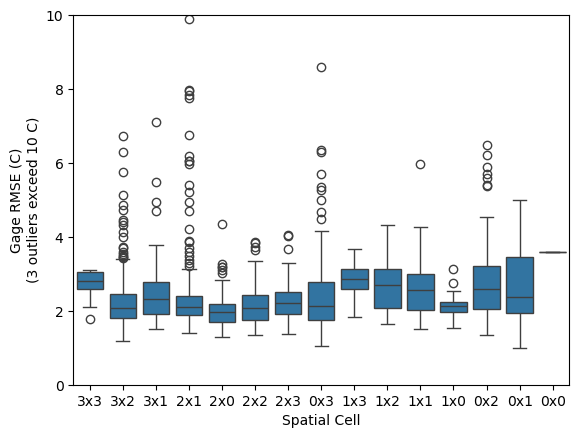

In [66]:
ax = sns.boxplot(spatperf, x="cell", y="RMSE")
ax.set_xlabel("Spatial Cell")
ax.set_ylabel("Gage RMSE (C)\n(3 outliers exceed 10 C)")
ax.set_ylim(0, 10)

## Elevation

For elevation extrapolation, we train on the lower 95% and test on the upper 5%.  We also just plot errors by elevation.

### Non-Extrapolating

To look at bias, remove the `.abs()`.  There is no trend in bias and a modest trend in absolute error (about 2 -> 2.6 C in the combined cross-validation and test sets).  However, this seems to be because median errors are very high in the 2000-2500 m range; otherwise, there's no obvious trend.  With that group removed, the trend is present but weaker.

In [72]:
preds = pd.read_csv(bp + "results/TestSet_hindcast.csv", dtype={"id": "str"}, parse_dates=["date"])
kfr = pd.read_csv(bp + "results/kfold.csv", dtype={"id": "str"}, parse_dates=["date"])
cols = ["id", "elev_min", "date", "temp.mod", "temperature"]
preds = pd.concat([preds[cols], kfr[cols]])

In [73]:
preds["error"] = (preds["temp.mod"] - preds["temperature"]).abs()
elev_perf = preds.groupby("id")[["elev_min", "error"]].mean()

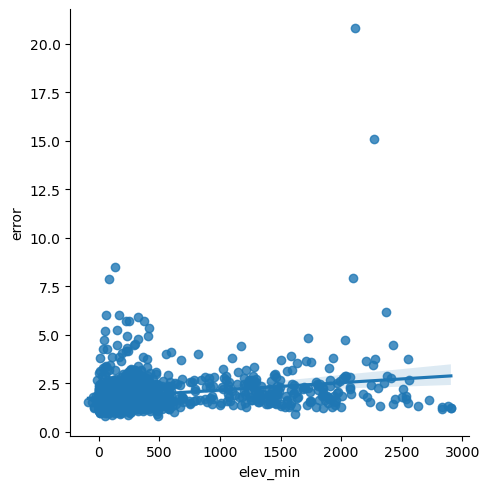

In [75]:
sns.lmplot(elev_perf, x="elev_min", y="error")

In [31]:
elev_perf.assign(elev_bucket = lambda x: x["elev_min"] // 500).groupby("elev_bucket").median()

,elev_min,error
elev_bucket,,
-1.0,-0.904104,1.544771
0.0,183.398407,1.645350
1.0,620.475739,1.780466
2.0,1270.442627,2.068409
3.0,1747.874878,1.927035
4.0,2225.939331,2.768274
5.0,2596.154053,1.547623


### Extrapolating

In [76]:
all_data["elev_min"].quantile(0.95)

1804.63671875

In [77]:
train = all_data[all_data["elev_min"] < 1800]
test = all_data[all_data["elev_min"] >= 1800]

In [78]:
len(test["id"].unique())

73

In [79]:
def predict(model, ws):
    print("|", end="")
    return model.run(ws, reset=True)

with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(train)
    prd = test.groupby("id").apply(lambda x: predict(model, x), include_groups=False).reset_index().drop(columns="level_1")

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Extrapolating to high elevation increases median RMSE to 2.7 C.  This (0.6 C) is about half the penalty observed in TempEst 1/2.  Promising.  Interestingly, it underestimates, rather than overestimates, high-elevation temperatures, unlike TE 1/2.  This penalty, unlike the above trend, does not result from the 2000-2500 m high-error cluster; the 14 gages above 2500 m have higher errors, at a median RMSE of 3.1 C.  Bias steadily increases with elevation, up to around -3 C for the highest gages, but this only occurs in extrapolation, not when there are training data at a comparable elevation.

In [80]:
with warnings.catch_warnings(action="ignore"):
    perf = prd.groupby(["id", "lat", "lon", "elev_min"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index().drop(columns="level_4")
perf.describe()

,lat,lon,elev_min,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,40.776704,-109.867806,2166.425646,0.834400,3.413165,-3.848350,0.964666,0.886596,0.255102,-14.843781,-1.840955,5.052409
std,2.618790,3.935740,311.234666,0.140441,3.145140,32.904710,0.021464,0.124374,0.184510,24.910947,3.624385,3.577325
min,35.777114,-120.237979,1801.255615,0.036224,1.631537,-279.671319,0.911176,0.175511,-0.782043,-78.480712,-22.889334,0.523877
25%,38.919908,-110.871600,1905.447998,0.804311,2.267370,0.287240,0.951346,0.868571,0.189622,-30.089427,-2.668666,2.827571
50%,40.108596,-108.297588,2071.349121,0.869709,2.651656,0.697899,0.971764,0.909121,0.273963,-12.351512,-1.200093,4.787392
75%,43.458361,-106.940958,2378.006348,0.906169,3.359075,0.810534,0.982201,0.942254,0.367319,-0.011009,-0.000738,6.199341
max,45.617967,-105.584139,2905.092529,0.952879,23.583269,0.924855,0.994626,0.985451,0.554326,65.192843,2.330759,22.712014


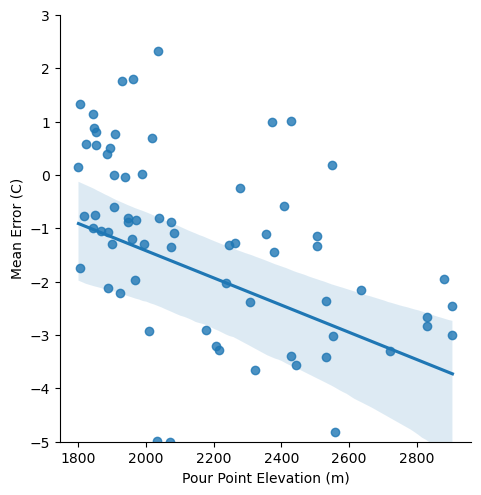

In [89]:
ax = sns.lmplot(perf, x="elev_min", y="Bias")
ax.set_axis_labels("Pour Point Elevation (m)", "Mean Error (C)")
ax.set(ylim=(-5, 3))

## Walk-Forward

For walk-forward validation, we train a model on all sites up to a given year, then predict the next year.  This is done for all prediction years from 2010-2022, allowing ten years of initial training data.  Each year should take about 15 minutes.

In [92]:
all_data["year"] = all_data["date"].dt.year
years = list(range(2010, 2023))
file = bp + "results/WalkForward.csv"
rerun = False
def runner(year):
    print(year)
    model = NEXT.NEXT.from_data(all_data[all_data["year"] < year])
    inp = all_data[all_data["year"] == year]
    return inp.groupby("id").apply(lambda x: model.run(x, reset=True, use_climate=False), include_groups=False)
if not rerun and os.path.exists(file):
    wfv = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
else:
    wfv = pd.concat([runner(year) for year in years])
    wfv.to_csv(file, index_label="id")

# Regime Shift/Disturbance

# Small Stream

# True Forecast